# Comparing ML Algorithms in Darts Models to Predict Wind Direction and Speed in Bauchi State Nigeria (EDA)
Accurate prediction of wind direction and speed are important for various sectors, including aviation, energy production, and public safety. This work is motivated by the need to improve the accuracy and efficiency of wind direction and speed forecasts in Nigeria, which can have significant impacts on various sectors.

Our aim is to therefore compare different ML algorithms to know how accurately we can predict `wind direction` and `wind speed` in Bauchi State, a Northern Nigerian State using the different machine learning algorithms available in Darts Model. This work can inform other States prediction with available data.

Carefully considering the scope and objectives of our research project and the resources available, such as computational power, time, and data quality, to decide on the forecast horizons to evaluate and with the aim to provide a comprehensive analysis, we wil be evaluating the models over `1 hour, 2 hours, 6 hours, 12 hours, 24 hours, 48 hours, and 72 hours` lag. This would allow us to examine the strengths and weaknesses of the different models across a range of forecast horizons, which could be useful across various applications and sectors.

## Choosing the Metrics to Measure Performance of our Model
We will also consider different evaluation metrics, such as mean absolute error (MAE) and root mean squared error (RMSE) to assess the accuracy and reliability of the different models. This would enable us to provide a more comprehensive analysis of the performance of the models and their suitability for different applications and sectors.

The first step here is to conduct EDA on our data to find patterns which would inform futher feature engineering and model selection.

## Loading, Cleaning and Exploring our Data

The data for this study is obtained from the data repository for solar and meteorological ground measurements from a network of weather stations in West Africa, provided in the framework of the West African Power Pool project: "Solar Development in Sub-Saharan Africa - Solar resource measurement campaign in West Africa" (Affolter, 2022). The data includes per second measurements of wind direction and speed, as well as solar radiation intensity, for a period of at least one year to ensure sufficient sample size and to capture seasonal variations in wind direction and speed.

### Data Description
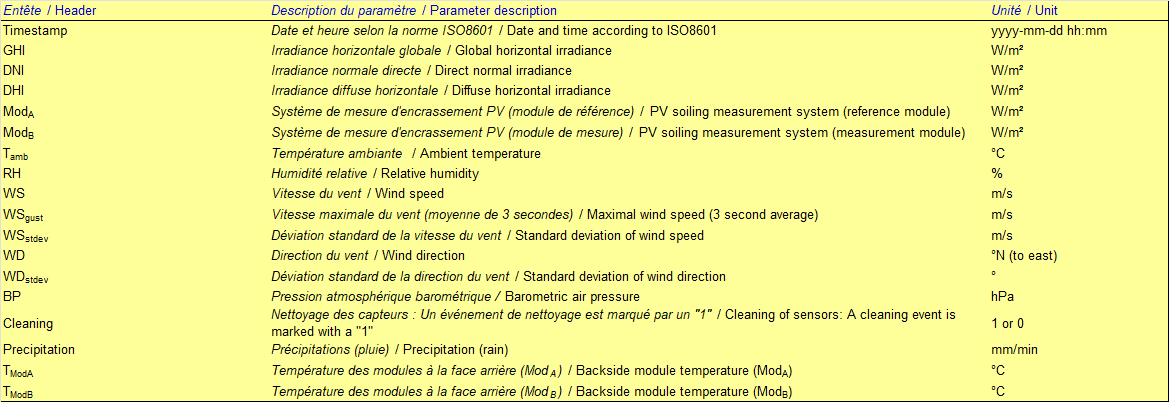

**Here are few things we will do in this section:**
- Check for missing values: Use the isnull() method to check if there are any missing values in each dataframe. If there are missing values, we would decide how to handle them, whether it's by dropping the rows/columns with missing values, filling in the missing values with a specific value or interpolation, or any other method.

- Check data types: Ensure that each column has the correct data type. For example, the Timestamp column should be of datetime type, while the other columns with numeric values should be of float or integer type.

- Explore the data: calculate summary statistics for each column, visualize the distribution of each variable, and check for any trends or patterns in the data.

- Consider feature engineering: Depending on our problem statement and the models we plan to use, we could create new features from the existing data. For example, we could extract the hour of the day or day of the week from the timestamp column to see if there are any patterns based on time.

Let's go ahead to load our data.

In [ ]:
# load all our packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# load model packages
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller  
from numpy import log
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from prophet import Prophet

# Set the Seaborn theme
sns.set()

In [ ]:
# Select columns to use
use_col = ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WSgust', 'BP', 'Precipitation', 'TModA', 'TModB', 'WS', 'WD']

# load Bauchi data
path = '/content/drive/MyDrive/DS-ML projects/Predicting Wind Direction and Speed/data/solar-measurements_nigeria-bauchi_qc.csv'
df = pd.read_csv(path, skiprows=[1], encoding='unicode_escape', usecols = use_col, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df = df.replace("NAN", np.nan)

Based on the above, the first row contain the column name, and the second row contain the unit of measurement. We dropped the second row that contains the unit of measurement when loading, as we do not need it. The skiprows parameter was set to [1] to skip the second row that contains the unit of measurement. Also, our data has an encoding, so we used a `unicode_escape` encoding method. We also parsed the `Timestamp` column as dates and made as our index column.

We currently do not have any missing data, therefore there would be no need to address missing values through interpolation with nearest numbers.

Since we have our data in per second, which is too granular, it would be good to resample our data into hourly data, generating additional features for Max, Mean and circular mean for wind direction to see if this still gives us similar distribution as our original per second data. Furthermore, since we will be comparing prediction for the next 1 hour, 3 hours, 6 hours, 12 hours, 24 hours, 48 hours, and 72 hours, we need to aggregate our data into 1-hour intervals, then use the aggregated data to train our model, which makes it important to go through this step.

To do this, we will resample our data using the resample() method, which is a powerful tool in pandas for time-series data. For all the variables, including wind speed we will aggregate the mean and max for each hour. However, for wind direction which is a circular data, we will use the circular mean or the mean resultant vector. The mean resultant vector is calculated using the trigonometric functions sine and cosine of the wind direction angles.

We can calculate the mean resultant vector as follows:
- Convert the wind direction angles (in degrees) to radians.
- Calculate the mean of the sines and cosines of the wind direction angles.
- Calculate the circular mean direction (in radians) using the arctangent function.
- Convert the circular mean direction back to degrees: We will define a function for taking the average of wind direction. The function first converts the input wind direction data x from degrees to radians using np.radians(x). It then takes the mean of the cosine and sine of the input data using np.mean(np.cos(x)) and np.mean(np.sin(x)), respectively. The mean wind direction is calculated using the arctan2() function, which returns the angle between the positive x-axis and a point given in polar coordinates (i.e., the sine and cosine of the angle). Finally, the function converts the result back to degrees using np.degrees() and applies modulo 360 to ensure that the output falls within the range of 0 to 360 degrees. This approach is known as the circular mean or directional statistics, and it is a well-established technique for calculating the mean direction of circular data such as wind direction. The circ_mean() function implements this technique correctly and efficiently using NumPy functions, making it a good choice for this task.

We will also be summing precipitation because precipitation is the amount of rainfall measured over a certain period of time, usually over an hour. Therefore, by summing precipitation over the hour, we get the total amount of rainfall over that period, which is a useful measure of weather conditions. If we averaged precipitation, it would not give us an accurate representation of the amount of rainfall during that hour.

In [ ]:
# Define function to calculate circular mean of wind direction
def circ_mean(x):
    x = np.radians(x)
    x_cos = np.mean(np.cos(x))
    x_sin = np.mean(np.sin(x))
    x_mean = np.arctan2(x_sin, x_cos)
    x_mean = np.degrees(x_mean) % 360
    return x_mean

# # Resample df to 1-hour intervals, calculating mean and max of each column
# df_hourly = df.resample('1H').agg({'GHI': ['mean', 'max'],
#                                    'DNI': ['mean', 'max'],
#                                    'DHI': ['mean', 'max'],
#                                    'ModA': ['mean', 'max'],
#                                    'ModB': ['mean', 'max'],
#                                    'Tamb': ['mean', 'max'],
#                                    'RH': ['mean', 'max'],
#                                    'WS': ['mean', 'max'],
#                                    'WSgust': ['mean', 'max'],
#                                    'WSstdev': ['mean'],
#                                    'WD': circ_mean,
#                                    'WDstdev': circ_mean,
#                                    'BP': ['mean', 'max'],
#                                    'Cleaning': 'sum',
#                                    'Precipitation': 'sum',
#                                    'TModA': ['mean', 'max'],
#                                    'TModB': ['mean', 'max']})

# Resample df to 1-hour intervals, calculating mean and max of selected column
df_hourly = df.resample('1H').agg({'GHI': ['mean'],
                                   'DNI': ['mean'],
                                   'DHI': ['mean'],
                                   'ModA': ['mean'],
                                   'ModB': ['mean'],
                                   'Tamb': ['mean'],
                                   'RH': ['mean'],
                                   'WSgust': ['mean'],
                                   'BP': ['mean'],
                                   'Precipitation': 'sum',
                                   'TModA': ['mean'],
                                   'TModB': ['mean'],
                                   'WS': ['mean'],
                                   'WD': circ_mean})

# Flatten column headers for df_hourly
df_hourly.columns = [f'{col[0]}_{col[1].upper()}' for col in df_hourly.columns]
df_hourly.reset_index(inplace=True)

# Round the float columns to 1 decimal place in df_hourly
float_cols = df_hourly.select_dtypes(include='float').columns
df_hourly[float_cols] = df_hourly[float_cols].round(1)

# Set Timestamp column as index and rename it
df_hourly = df_hourly.set_index('Timestamp')

In [ ]:
print(f'displaying first 5 Original data')
display(df.head())
print("\n")
print(f'displaying first 5 1-hour Resampled data')
display(df_hourly.head())

displaying first 5 Original data


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WD,BP,Precipitation,TModA,TModB
Timestamp,,,,,,,,,,,,,,
2021-09-20 00:01:00,-1.2,-0.3,-1.4,0.0,0.0,22.3,93.1,0.0,0.0,0.0,948,0.0,21.4,21.6
2021-09-20 00:02:00,-1.2,-0.3,-1.5,0.0,0.0,22.3,92.5,0.0,0.0,0.0,948,0.0,21.4,21.6
2021-09-20 00:03:00,-1.2,-0.3,-1.4,0.0,0.0,22.3,92.3,0.0,0.0,0.0,948,0.0,21.4,21.6
2021-09-20 00:04:00,-1.2,-0.3,-1.5,0.0,0.0,22.3,92.4,0.0,0.0,0.0,948,0.0,21.4,21.6
2021-09-20 00:05:00,-1.2,-0.3,-1.5,0.0,0.0,22.3,92.2,0.0,0.0,0.0,948,0.0,21.4,21.6




displaying first 5 1-hour Resampled data


,GHI_MEAN,DNI_MEAN,DHI_MEAN,ModA_MEAN,ModB_MEAN,Tamb_MEAN,RH_MEAN,WSgust_MEAN,BP_MEAN,Precipitation_SUM,TModA_MEAN,TModB_MEAN,WS_MEAN,WD_CIRC_MEAN
Timestamp,,,,,,,,,,,,,,
2021-09-20 00:00:00,-1.0,-0.2,-1.2,0.0,0.0,22.2,93.8,0.5,947.5,0.0,21.5,21.8,0.3,314.6
2021-09-20 01:00:00,-0.9,-0.2,-1.2,0.0,0.0,22.4,92.9,0.7,947.0,0.0,21.8,22.2,0.4,287.2
2021-09-20 02:00:00,-1.4,-0.4,-1.6,0.0,0.0,21.6,93.9,0.5,946.3,0.0,20.3,20.6,0.3,304.1
2021-09-20 03:00:00,-1.8,-0.4,-2.0,0.0,0.0,20.6,96.2,0.8,945.7,0.0,19.5,19.9,0.5,276.1
2021-09-20 04:00:00,-1.9,-0.4,-2.1,0.0,0.0,20.9,95.4,1.1,945.6,0.0,19.9,20.1,0.7,255.7


In [ ]:
print(f'displaying info of Original data')
df.info()
print("\n")
print(f'displaying info of 1-hr resampled data')
df_hourly.info()

displaying info of Original data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-09-20 00:01:00 to 2022-09-20 00:00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WD             525600 non-null  float64
 10  BP             525600 non-null  int64  
 11  Precipitation  525600 non-null  float64
 12  TModA          525600 non-null  float64
 13  TModB          525600 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 60.2 MB


displaying info of 1-hr resampled data
<class 'p

In [ ]:
print(f'displaying description of Original data')
df_desc = df.describe()
df_desc.to_csv('df_desc_output.csv')
display(df_desc)

print("\n")

print(f'displaying description of 1-hr resampled data')
df_hourly_desc = df_hourly.describe()
df_hourly_desc.to_csv('df_hourly_desc_output.csv')
display(df_hourly_desc)

displaying description of Original data


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WD,BP,Precipitation,TModA,TModB
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000
mean,228.137693,158.107517,111.612046,223.799722,219.448294,25.931232,51.355592,2.095550,2.863114,133.470654,947.334159,0.002345,34.774615,32.618297
std,326.783026,261.526572,159.542597,315.792976,310.197826,5.416719,28.919370,1.685211,2.093465,115.789747,2.267810,0.039912,18.464523,14.621267
min,-14.000000,-6.100000,-14.700000,0.000000,0.000000,10.800000,3.600000,0.000000,0.000000,0.000000,938.000000,0.000000,7.100000,7.500000
25%,-6.300000,-0.500000,-4.700000,0.000000,0.000000,22.100000,23.000000,0.600000,1.400000,23.500000,946.000000,0.000000,21.400000,21.900000
50%,-0.500000,-0.100000,-0.200000,3.700000,3.600000,25.300000,52.200000,2.000000,2.700000,112.200000,947.000000,0.000000,26.100000,26.600000
75%,445.500000,264.300000,208.100000,424.600000,413.200000,29.700000,79.000000,3.200000,4.200000,223.625000,949.000000,0.000000,48.800000,43.900000
max,1474.000000,958.300000,789.900000,1388.000000,1405.000000,42.000000,99.800000,24.100000,30.700000,360.000000,956.000000,3.200000,89.100000,76.500000




displaying description of 1-hr resampled data


,GHI_MEAN,DNI_MEAN,DHI_MEAN,ModA_MEAN,ModB_MEAN,Tamb_MEAN,RH_MEAN,WSgust_MEAN,BP_MEAN,Precipitation_SUM,TModA_MEAN,TModB_MEAN,WS_MEAN,WD_CIRC_MEAN
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,228.111528,158.090104,111.599406,223.773519,219.423080,25.930636,51.360644,2.862584,947.334585,0.140703,34.773211,32.616733,2.095138,167.860929
std,320.142877,252.198604,157.162072,309.869612,304.160535,5.389857,28.861356,1.863062,2.240972,1.504635,18.273089,14.473795,1.486114,123.027362
min,-12.700000,-3.200000,-13.600000,0.000000,0.000000,11.400000,4.000000,0.000000,938.200000,0.000000,7.700000,8.000000,0.000000,0.000000
25%,-5.500000,-0.400000,-4.200000,0.000000,0.000000,22.100000,23.100000,1.400000,946.000000,0.000000,21.500000,21.900000,0.800000,45.400000
50%,3.400000,-0.100000,4.000000,9.300000,9.100000,25.300000,52.300000,2.800000,947.200000,0.000000,26.200000,26.700000,2.000000,178.800000
75%,457.800000,272.500000,211.500000,440.500000,431.500000,29.700000,79.000000,4.200000,949.000000,0.000000,48.800000,44.200000,3.100000,290.900000
max,1065.800000,940.700000,699.800000,1033.000000,1035.700000,41.600000,99.600000,12.900000,956.000000,56.900000,84.700000,73.500000,10.400000,360.000000


In [ ]:
def show_distribution(var_data, suptitle):
    from matplotlib import pyplot as plt

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    title = f"Distribution of {suptitle}\nMinimum: {min_val:.2f}, \nMean: {mean_val:.2f}, \nMedian: {med_val:.2f}, \nMode: {mod_val:.2f}, \nMaximum: {max_val:.2f}"
    # print(title)

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize=(7, 5))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color='gray', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mean_val, color='cyan', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=med_val, color='red', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=mod_val, color='yellow', linestyle='dashed', linewidth=2)
    ax[0].axvline(x=max_val, color='gray', linestyle='dashed', linewidth=2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(title, fontsize=11)

    # Show the figure
    fig.tight_layout(pad=1.0, w_pad=0.5, h_pad=1.0)
    fig.show()

In [ ]:
def show_density(var_data, chart_title):
    from matplotlib import pyplot as plt

    fig = plt.figure(figsize=(7,5))

    # Plot density
    var_data.plot.density()

    # Add titles and labels
    plt.title(chart_title)

    # Show the mean, median, and mode
    plt.axvline(x=var_data.mean(), color = 'cyan', linestyle='dashed', linewidth = 2)
    plt.axvline(x=var_data.median(), color = 'red', linestyle='dashed', linewidth = 2)
    plt.axvline(x=var_data.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2)

    # Show the figure
    plt.show()

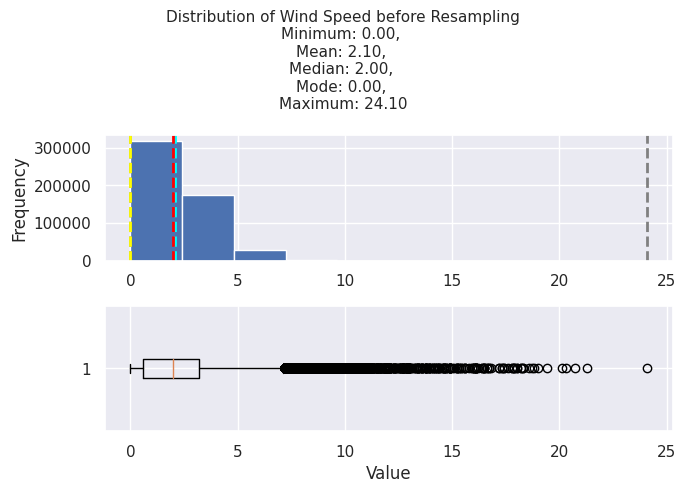

In [ ]:
show_distribution(df["WS"], "Wind Speed before Resampling")

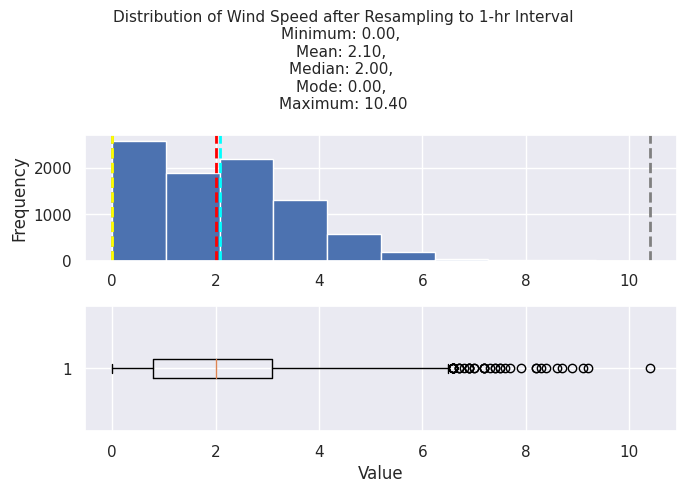

In [ ]:
show_distribution(df_hourly["WS_MEAN"], "Wind Speed after Resampling to 1-hr Interval")

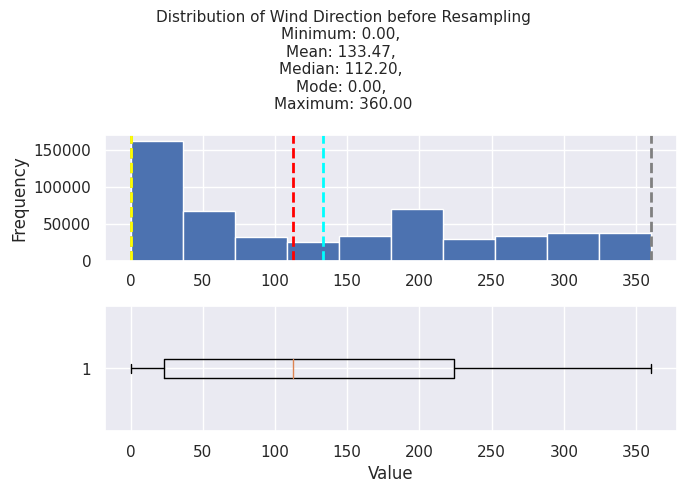

In [ ]:
show_distribution(df["WD"], "Wind Direction before Resampling")

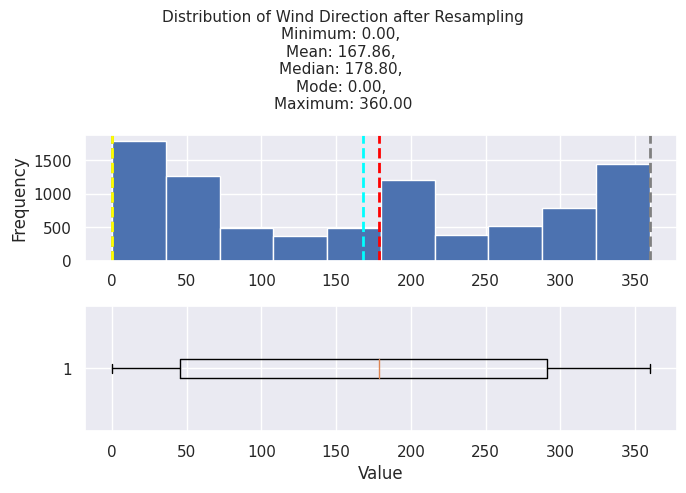

In [ ]:
show_distribution(df_hourly["WD_CIRC_MEAN"], "Wind Direction after Resampling")

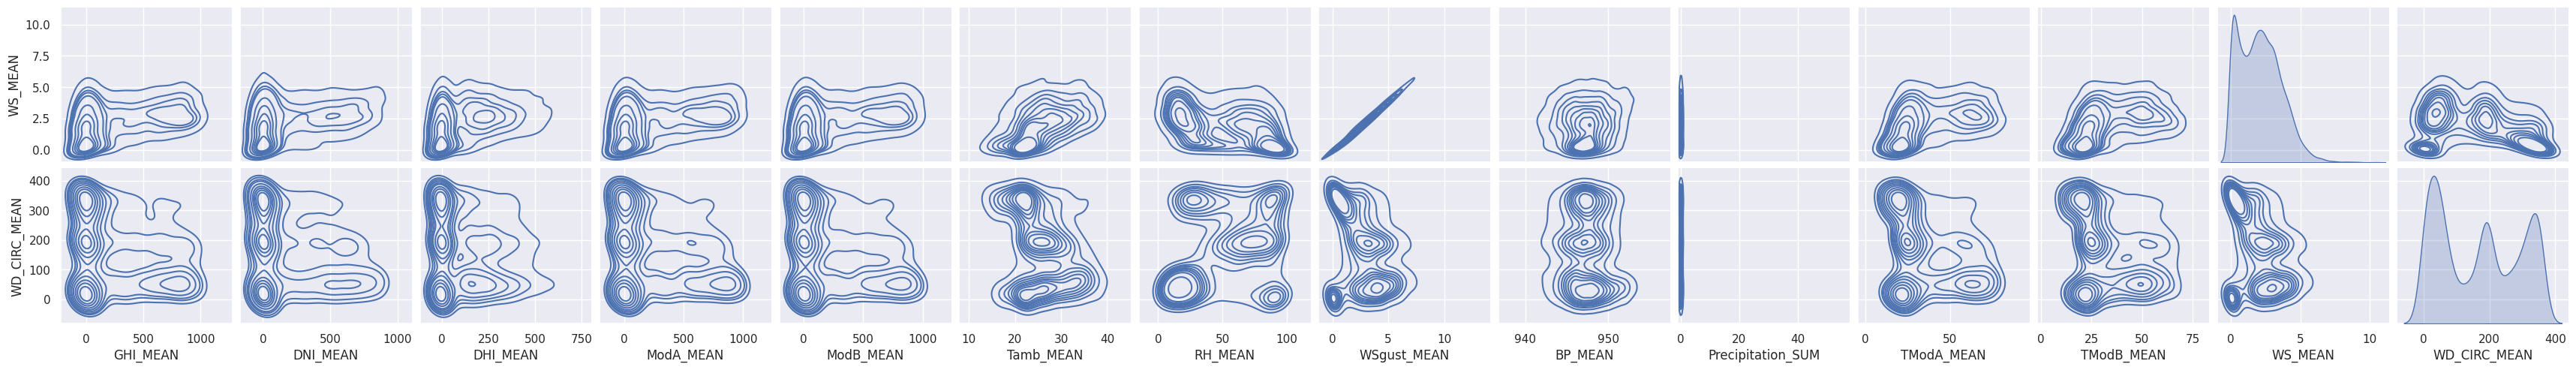

In [ ]:
sns.pairplot(df_hourly, kind="kde", y_vars = ["WS_MEAN", "WD_CIRC_MEAN"])

In [ ]:
sns.pairplot(df_hourly, kind="kde", corner=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g = sns.PairGrid(df_hourly, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

Output hidden; open in https://colab.research.google.com to view.

## Exploratory Data Analysis
Now that we have our data cleaned and set, we will go ahead to conduct EDA and visualization on each State data, side by side.

### Comparing Different time features to check patterns across the variables.
It is generally a good practice to extract meaningful features from the timestamp if it can help in better understanding the data and extracting more insights. Hour of the day, Month of the year, Day of the Month, Day of the Week, Week of the Month and Week of the Year are all meaningful features that could provide useful insights, which we can extract from our `Timestamp`. Therefore, we will go ahead to plot each of these different time features against each of our variables. We will use box plot to help us visually view the distribution across these time frames.

Let's first define a function to help us plot each time feature.

In [ ]:
 def plot_time_pattern(df, val, val_desc):
  
  # Create a copy of the dataframe
  df_time = df.copy()

  # Create new columns for year, month, day, hour, and weekofmonth
  df_time["year"] = df_time.index.year
  df_time["month"] = df_time.index.month
  df_time["day"] = df_time.index.day
  df_time["hour"] = df_time.index.hour
  df_time["weekofmonth"] = ((df_time.index.day - 1) // 7 + 1)

  # Define a helper function for groupby and pivot operations
  def group_pivot(groupby_cols, pivot_index, pivot_columns):
      agg = df_time.groupby(groupby_cols).mean().reset_index().pivot(index=pivot_index, columns=pivot_columns, values=val)
      return agg

  # Define the heatmap parameters
  heatmap_params = {'cmap': 'coolwarm', 'cbar_kws': {'label': val_desc}}

  # Create a 2x2 subplot grid
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

  # Define the different plots to generate
  plots = [("Hour of the Day", ["day", "hour"], "day", "hour"),
            ("Day of the Month", ["month", "day"], "month", "day"),
            ("Week of the Month", ["month", "weekofmonth"], "month", "weekofmonth"),
            ("Month of the Year", ["year", "month"], "year", "month")]

  # Generate each plot and set its properties
  for i, (title, groupby_cols, pivot_index, pivot_columns) in enumerate(plots):
      row = i // 2
      col = i % 2
      agg = group_pivot(groupby_cols, pivot_index, pivot_columns)
      sns.heatmap(agg, ax=axs[row][col], **heatmap_params)
      axs[row][col].set_xlabel(pivot_columns.capitalize())
      axs[row][col].set_ylabel(pivot_index.capitalize())
      axs[row][col].set_title(title)

  # Add a suptitle to the figure
  fig.suptitle(f"{val_desc} Patterns Across Time", fontsize=16)

  # Adjust the spacing between the subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

  return fig, axs

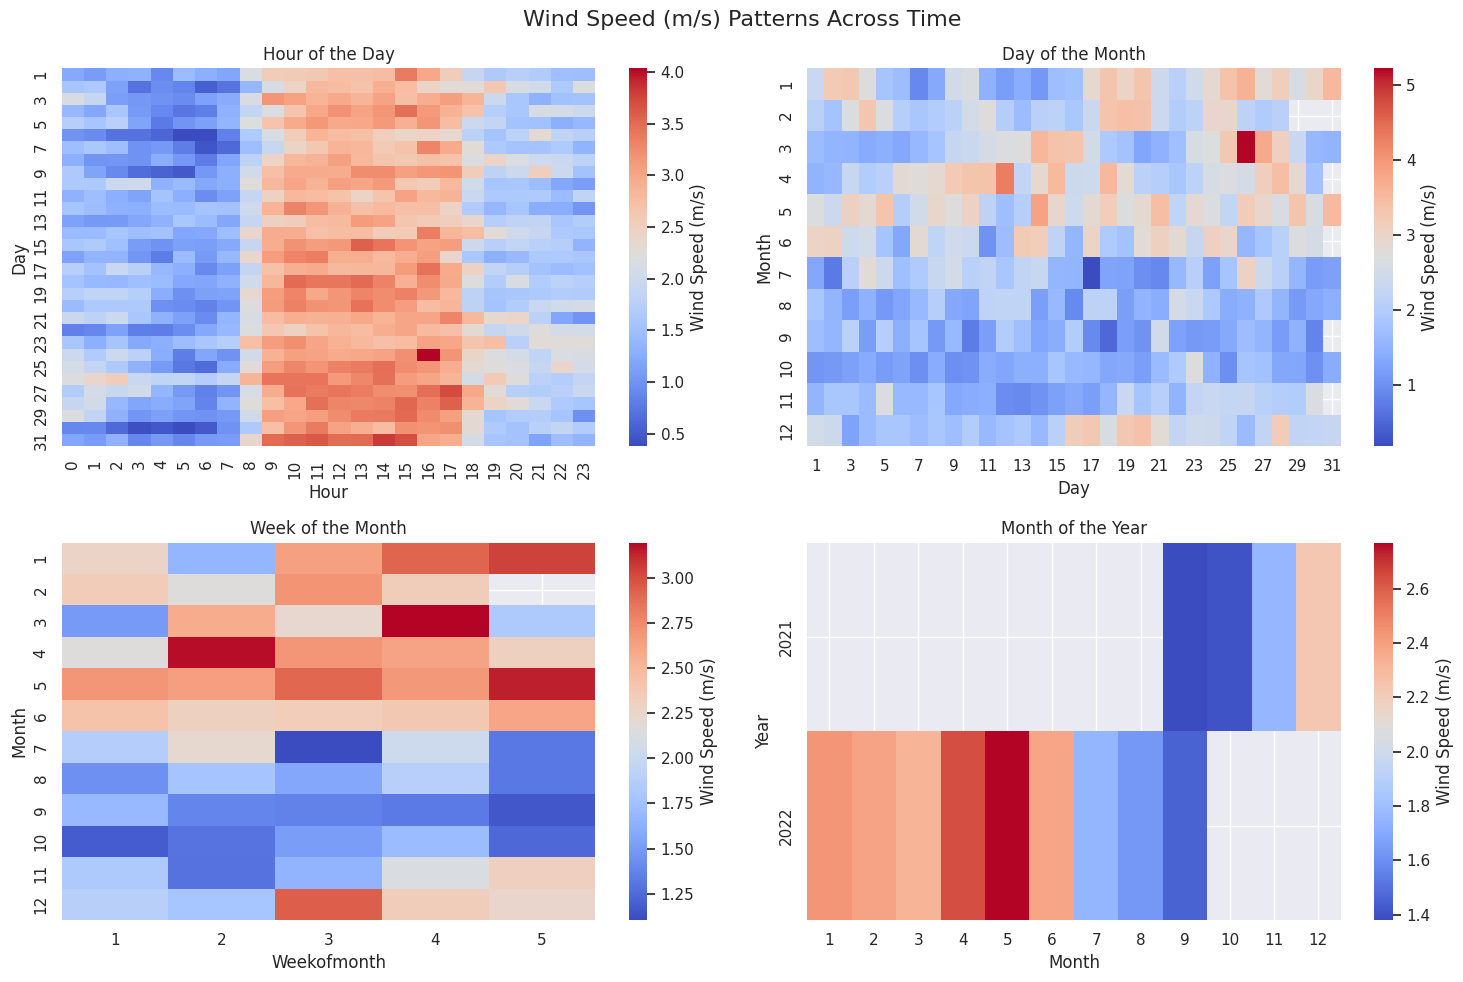

(<Figure size 1500x1000 with 8 Axes>,
 array([[<Axes: title={'center': 'Hour of the Day'}, xlabel='Hour', ylabel='Day'>,
         <Axes: title={'center': 'Day of the Month'}, xlabel='Day', ylabel='Month'>],
        [<Axes: title={'center': 'Week of the Month'}, xlabel='Weekofmonth', ylabel='Month'>,
         <Axes: title={'center': 'Month of the Year'}, xlabel='Month', ylabel='Year'>]],
       dtype=object))

In [ ]:
plot_time_pattern(df_hourly, val="WS_MEAN", val_desc="Wind Speed (m/s)")

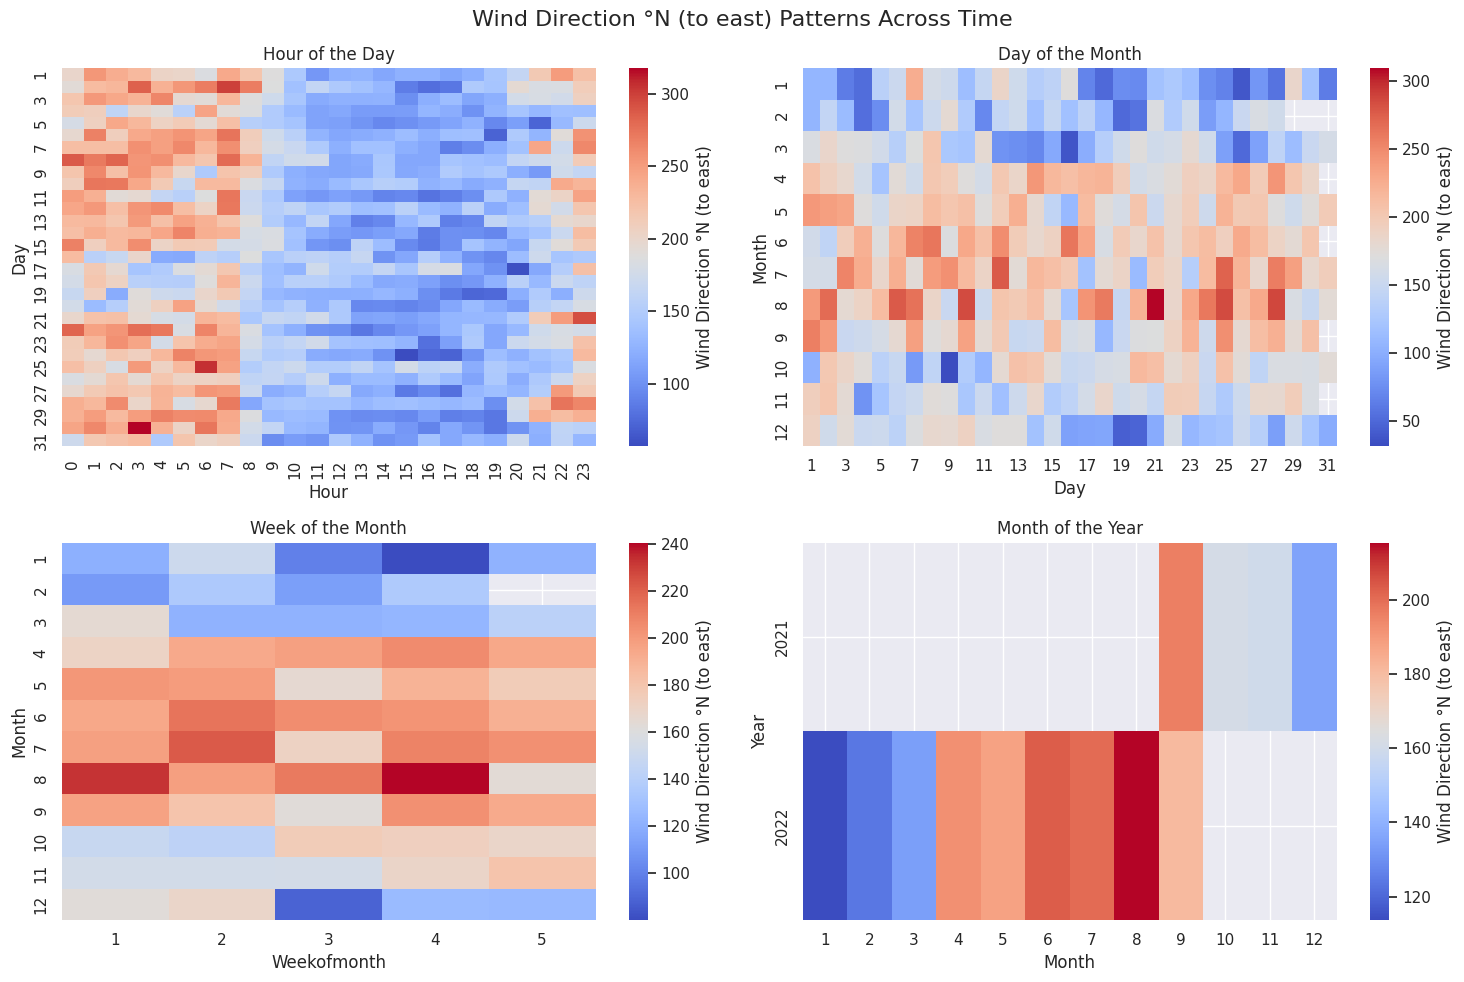

(<Figure size 1500x1000 with 8 Axes>,
 array([[<Axes: title={'center': 'Hour of the Day'}, xlabel='Hour', ylabel='Day'>,
         <Axes: title={'center': 'Day of the Month'}, xlabel='Day', ylabel='Month'>],
        [<Axes: title={'center': 'Week of the Month'}, xlabel='Weekofmonth', ylabel='Month'>,
         <Axes: title={'center': 'Month of the Year'}, xlabel='Month', ylabel='Year'>]],
       dtype=object))

In [ ]:
plot_time_pattern(df_hourly, val="WD_CIRC_MEAN", val_desc="Wind Direction °N (to east)")

Based on the above findings, since hour odf the day and month of the year showed patterns seasonally, we will therefore consider adding them as part of the features for our model training.

### Check the correlation between each feature
It would be good to look at the correlation between each feature in our data. This would help us to know how each feature affect each other, and how they equally affect our targets for this project.

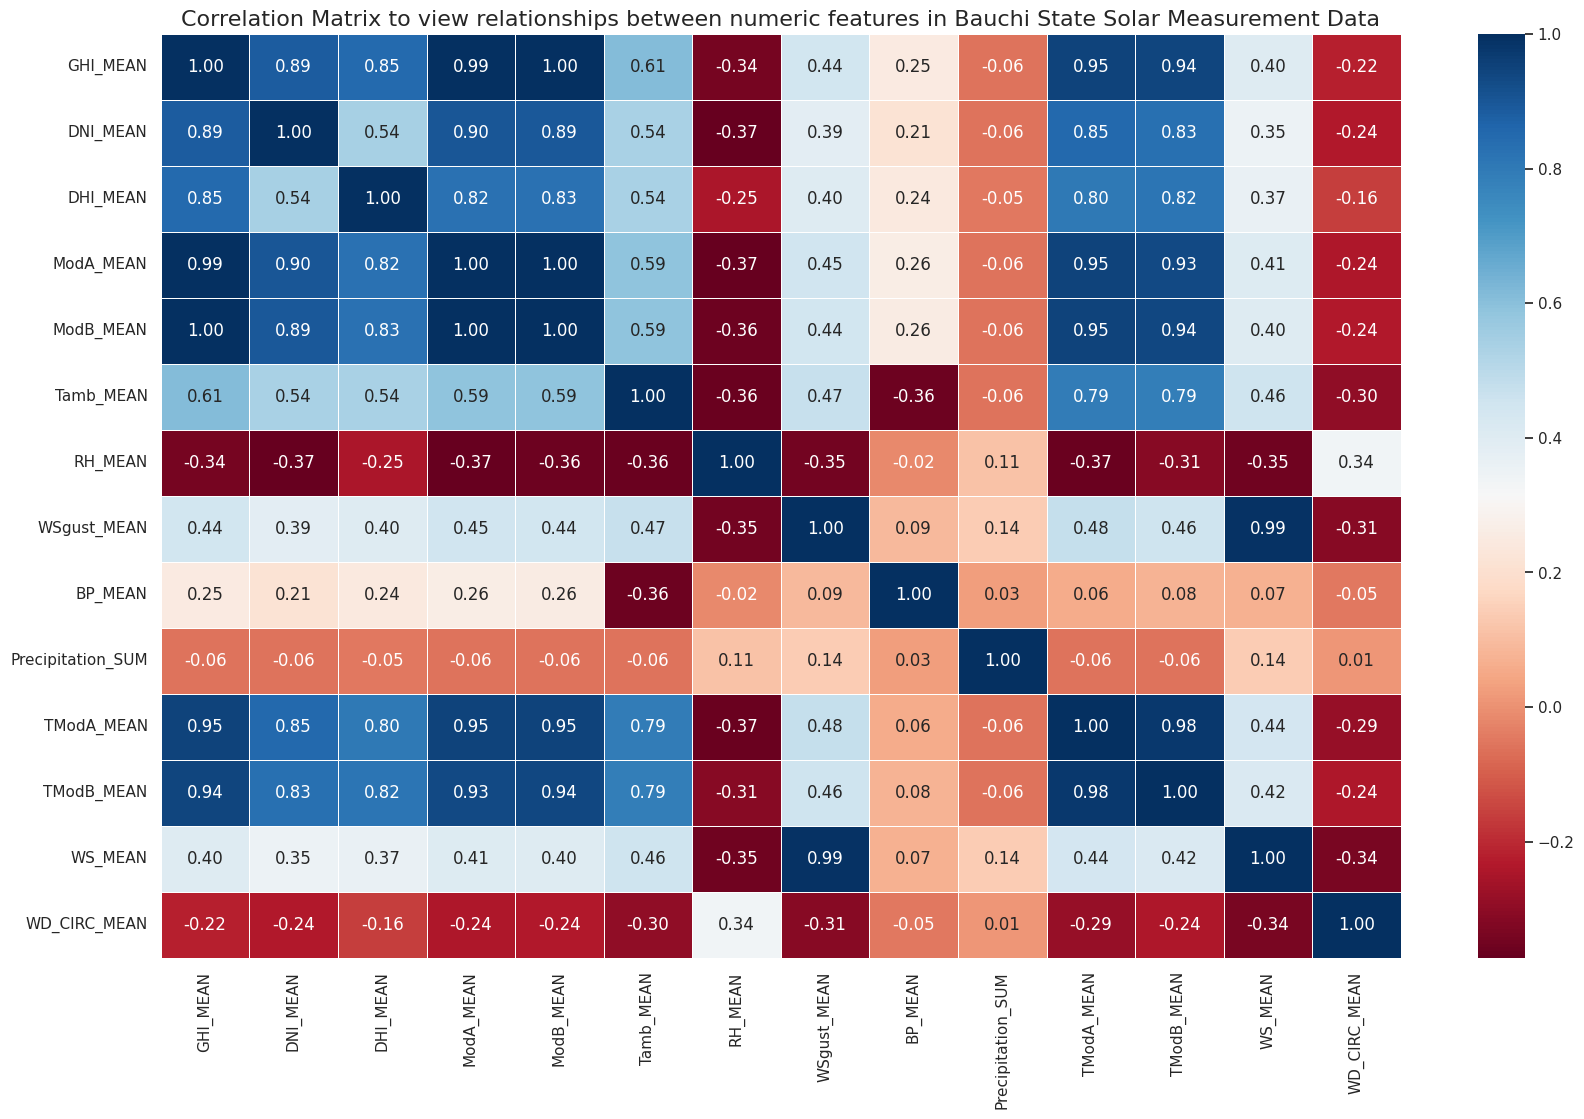

In [ ]:
# Check features correlation for Bauchi
corr_matrix = df_hourly.corr()
fig,ax = plt.subplots(figsize=(20,12))
plt.title("Correlation Matrix to view relationships between numeric features in Bauchi State Solar Measurement Data", fontsize=16)
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 fmt='.2f',  # Format annotations to 2 decimal places
                 linewidths=0.5,
                 cmap='RdBu');

Now that we have our data explored, it is time to start the model comparison. Before that, we will create a point to save our data, so we can easily commence from there going forward.

# Creating a Data Checkpoint
We will be saving a checkpoint of our `df_hourly` data, a process called "serialization". This would allow us to save our dataframe at this point and then resume from here later, without having to rerun the entire process from scratch. We will use the data for further preprocessing.

In [ ]:
# Export df_hourly to csv
df_hourly.to_csv("/content/drive/MyDrive/DS-ML projects/Predicting Wind Direction and Speed/data/bauchi-data-resampled-hourly-27042023.csv")